# Grid algorithm for a beta-binomial hierarchical model

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install libraries
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz
    !pip install empiricaldist

In [2]:
# PyMC generates a FutureWarning we don't need to deal with yet

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import matplotlib.pyplot as plt

def legend(**options):
    """Make a legend only if there are labels."""
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend(**options)

In [4]:
def decorate(**options):
    plt.gca().set(**options)
    legend()
    plt.tight_layout()

In [5]:
from empiricaldist import Cdf

def compare_cdf(pmf, sample):
    pmf.make_cdf().plot(label='grid')
    Cdf.from_seq(sample).plot(label='mcmc')
    print(pmf.mean(), sample.mean())
    decorate()

In [6]:
from empiricaldist import Pmf

def make_pmf(ps, qs, name):
    pmf = Pmf(ps, qs)
    pmf.normalize()
    pmf.index.name = name
    return pmf

## Heart Attack Data

This example is based on [Chapter 10 of *Probability and Bayesian Modeling*](https://bayesball.github.io/BOOK/bayesian-hierarchical-modeling.html#example-deaths-after-heart-attack); it uses data on death rates due to heart attack for patients treated at various hospitals in New York City.

We can use Pandas to read the data into a `DataFrame`.

In [7]:
import os

filename = 'DeathHeartAttackManhattan.csv'
if not os.path.exists(filename):
    !wget https://github.com/AllenDowney/BayesianInferencePyMC/raw/main/DeathHeartAttackManhattan.csv

In [8]:
import pandas as pd

df = pd.read_csv(filename)
df

,Hospital,Cases,Deaths,Death %
0,Bellevue Hospital Center,129,4,3.101
1,Harlem Hospital Center,35,1,2.857
2,Lenox Hill Hospital,228,18,7.894
3,Metropolitan Hospital Center,84,7,8.333
4,Mount Sinai Beth Israel,291,24,8.247
5,Mount Sinai Hospital,270,16,5.926
6,Mount Sinai Roosevelt,46,6,13.043
7,Mount Sinai St. Luke’s,293,19,6.485
8,NYU Hospitals Center,241,15,6.224
9,NYP Hospital - Allen Hospital,105,13,12.381


The columns we need are `Cases`, which is the number of patients treated at each hospital, and `Deaths`, which is the number of those patients who died.

In [9]:
data_ns = df['Cases'].values
data_ks = df['Deaths'].values

In [11]:
import numpy as np

logn = np.log(np.max(data_ns))
logn

5.8664680569332965

## Hospital Data with PyMC

Here's a hierarchical model that estimates the death rate for each hospital, and simultaneously estimates the distribution of rates across hospitals.

In [12]:
import pymc3 as pm

def make_model():
    with pm.Model() as model:
        mu = pm.Beta('mu', alpha=1, beta=1)
        eta = pm.Logistic('eta', mu=logn, s=1)
        alpha = pm.Deterministic('alpha', mu * eta)
        beta = pm.Deterministic('beta', (1-mu) * eta)
        xs = pm.Beta('xs', alpha, beta, shape=len(data_ns))
        ks = pm.Binomial('ks', n=data_ns, p=xs, observed=data_ks)
    return model

CPU times: user 1.03 s, sys: 49.4 ms, total: 1.08 s
Wall time: 2.4 s


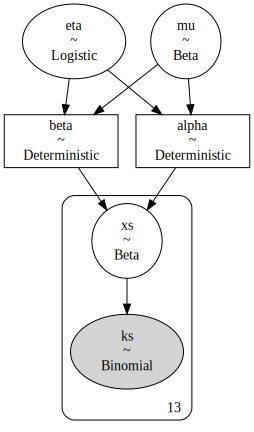

In [13]:
%time model = make_model()
pm.model_to_graphviz(model)

In [14]:
with model:
    # TODO: File bug report
    # pred = pm.sample_prior_predictive(1000)
    %time trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xs, eta, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


CPU times: user 6.77 s, sys: 216 ms, total: 6.98 s
Wall time: 8.31 s


Here are the posterior distributions of alpha and beta.

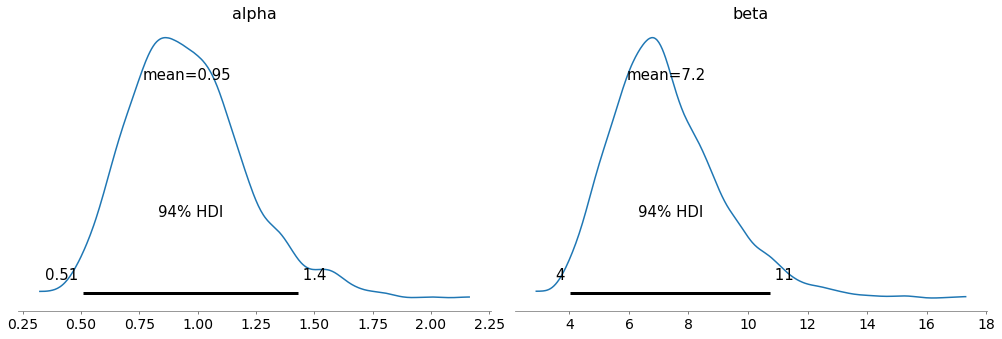

In [15]:
import arviz as az

with model:
    az.plot_posterior(trace, var_names=['alpha', 'beta'])

And we can extract the posterior distributions of the xs.

In [16]:
trace_xs = trace['xs'].transpose()
trace_xs.shape

(13, 2000)

As an example, here's the posterior distribution of x for the first hospital.

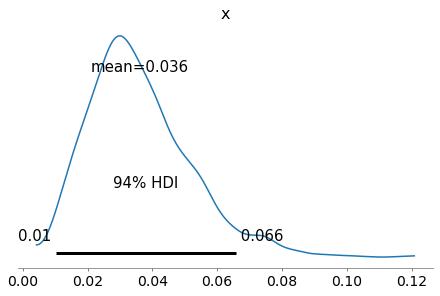

In [17]:
with model:
    az.plot_posterior(trace_xs[0])

## Just one update

In [18]:
i = 3
data_n = data_ns[i]
data_k = data_ks[i]

In [19]:
def make_model1():
    with pm.Model() as model1:
        mu = pm.Beta('mu', alpha=1, beta=1)
        eta = pm.Logistic('eta', mu=logn, s=1)
        alpha = pm.Deterministic('alpha', mu * eta)
        beta = pm.Deterministic('beta', (1-mu) * eta)
        x = pm.Beta('x', alpha, beta)
        k = pm.Binomial('k', n=data_n, p=x, observed=data_k)
    return model1

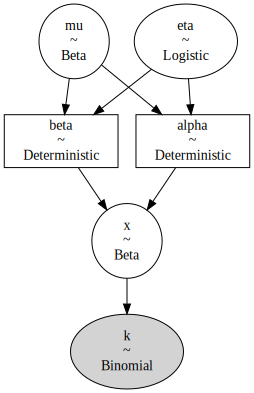

In [20]:
model1 = make_model1()
pm.model_to_graphviz(model1)

In [21]:
with model1:
    # pred1 = pm.sample_prior_predictive(1000)
    trace1 = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, eta, mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


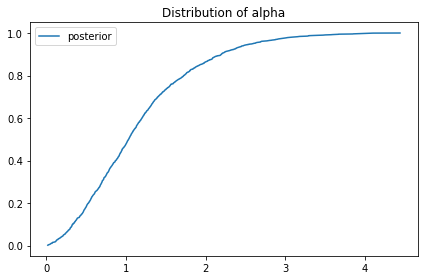

In [22]:
#Cdf.from_seq(pred1['alpha']).plot(label='prior', color='gray')
Cdf.from_seq(trace1['alpha']).plot(label='posterior')
decorate(title='Distribution of alpha')

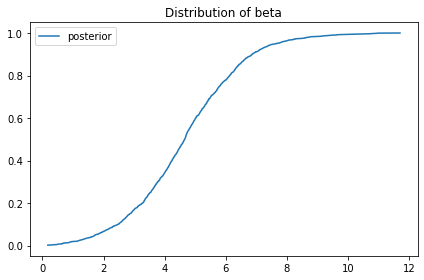

In [23]:
#Cdf.from_seq(pred1['beta']).plot(label='prior', color='gray')
Cdf.from_seq(trace1['beta']).plot(label='posterior')
decorate(title='Distribution of beta')

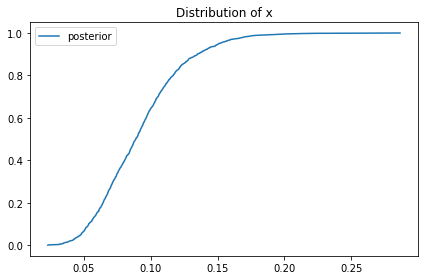

In [24]:
#Cdf.from_seq(pred1['x']).plot(label='prior', color='gray')
Cdf.from_seq(trace1['x']).plot(label='posterior')
decorate(title='Distribution of x')

## The grid priors

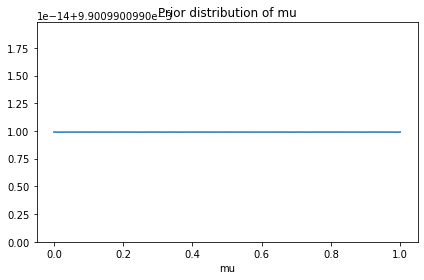

In [26]:
from scipy.stats import beta as betadist

mus = np.linspace(0, 1, 101)
ps = betadist.pdf(mus, 1, 1)
prior_mu = make_pmf(ps, mus, 'mu')

prior_mu.plot()
decorate(title='Prior distribution of mu')

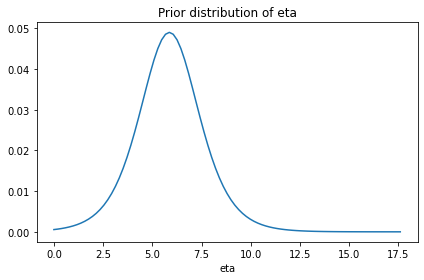

In [79]:
from scipy.stats import logistic

etas = np.linspace(0, 3*logn, 91)
ps = logistic.pdf(etas, loc=logn, scale=1)
prior_eta = make_pmf(ps, etas, 'eta')

prior_eta.plot()
decorate(title='Prior distribution of eta')

In [80]:
#TODO: Compare priors to the priors in the PyMC model

In [81]:
#compare_cdf(prior_mu, pred1['mu'])
#decorate(title='Prior distribution of mu')

In [82]:
#compare_cdf(prior_eta, pred1['eta'])
#decorate(title='Prior distribution of eta')

## The joint distribution of hyperparameters

In [83]:
# TODO: Change these variable names
def make_hyper(prior_alpha, prior_beta):
    PA, PB = np.meshgrid(prior_alpha.ps, prior_beta.ps, indexing='ij')
    hyper = PA * PB
    return hyper

In [84]:
prior_hyper = make_hyper(prior_mu, prior_eta)
prior_hyper.shape

(101, 91)

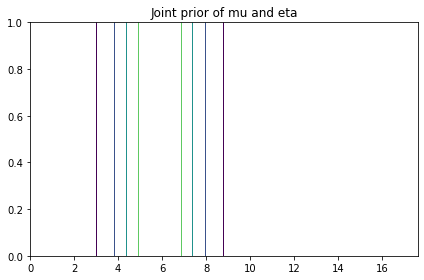

In [85]:
import pandas as pd
from utils import plot_contour

plot_contour(pd.DataFrame(prior_hyper, index=mus, columns=etas))
decorate(title="Joint prior of mu and eta")

## Joint prior of alpha, beta, and x

In [86]:
xs = np.linspace(0.01, 0.99, 99)

In [87]:
M, E, X = np.meshgrid(mus, etas, xs, indexing='ij')

In [88]:
A = M * E
B = (1-M) * E

In [89]:
from scipy.stats import beta as betadist

%time betapdf = betadist.pdf(X, A, B)

CPU times: user 458 ms, sys: 6.65 ms, total: 465 ms
Wall time: 461 ms


We can speed this up by computing just $x^{\alpha-1} (1-x)^{\beta-1}$ and skipping the terms that don't depend on x

In [90]:
logx = np.log(xs)
logy = np.log(1-xs)

In [91]:
logpdf = (A-1) * logx + (B-1) * logy
betapdf = np.exp(logpdf)

In [92]:
totals = betapdf.sum(axis=2)

In [93]:
shape = totals.shape + (1,)
betapdf /= totals.reshape(shape)

In [94]:
def make_prior(hyper):

    # reshape hyper so we can multiply along axis 0
    shape = hyper.shape + (1,)
    prior = betapdf * hyper.reshape(shape)

    return prior

In [95]:
%time prior = make_prior(prior_hyper)
prior.sum()

CPU times: user 1.72 ms, sys: 1.48 ms, total: 3.2 ms
Wall time: 1.84 ms


1.0000000000000002

The following function computes the marginal distributions.

In [96]:
def marginal(joint, axis):
    axes = [i for i in range(3) if i != axis]
    return joint.sum(axis=tuple(axes))

And let's confirm that the marginal distributions are what they are supposed to be.

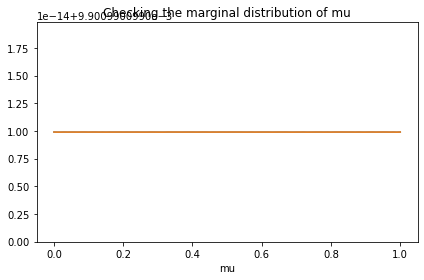

In [97]:
prior_mu.plot()
marginal_mu = Pmf(marginal(prior, 0), mus)
marginal_mu.plot()
decorate(title='Checking the marginal distribution of mu')

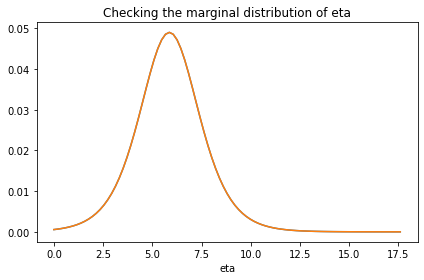

In [98]:
prior_eta.plot()
marginal_eta = Pmf(marginal(prior, 1), etas)
marginal_eta.plot()
decorate(title='Checking the marginal distribution of eta')

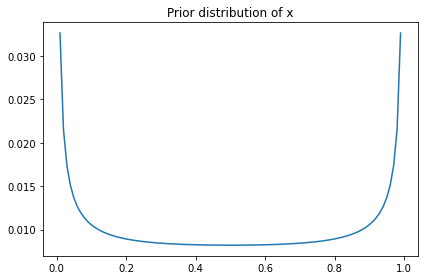

In [99]:
prior_x = Pmf(marginal(prior, 2), xs)
prior_x.plot()
decorate(title='Prior distribution of x')

In [100]:
# TODO: Compare to predictive distribution from PyMC
#marginal_x = Pmf(marginal(prior, 2), xs)
#compare_cdf(marginal_x, pred1['x'])
#decorate(title='Checking the marginal distribution of x')

In [101]:
def get_hyper(joint):
    return joint.sum(axis=2)

In [102]:
hyper = get_hyper(prior)

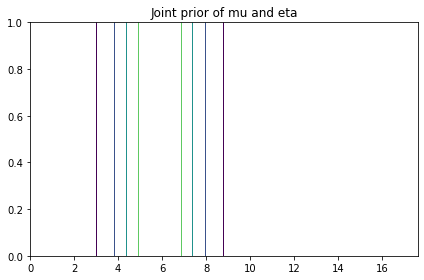

In [103]:
plot_contour(pd.DataFrame(hyper, 
                          index=mus, 
                          columns=etas))
decorate(title="Joint prior of mu and eta")

## The Update

In [104]:
from scipy.stats import binom

like_x = binom.pmf(data_k, data_n, xs)
like_x.shape

(99,)

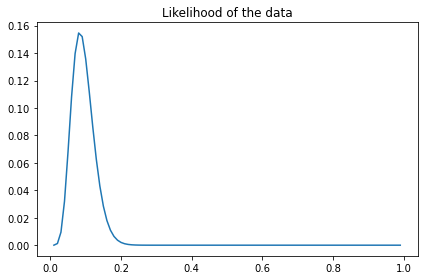

In [105]:
plt.plot(xs, like_x)
decorate(title='Likelihood of the data')

In [106]:
def update(prior, data):
    n, k = data
    like_x = binom.pmf(k, n, xs)

    posterior = prior * like_x
    posterior /= posterior.sum()
    return posterior

In [107]:
data = data_n, data_k
%time posterior = update(prior, data)

CPU times: user 2.94 ms, sys: 2.96 ms, total: 5.91 ms
Wall time: 3.69 ms


0.18516146005069983 0.20984857320073633


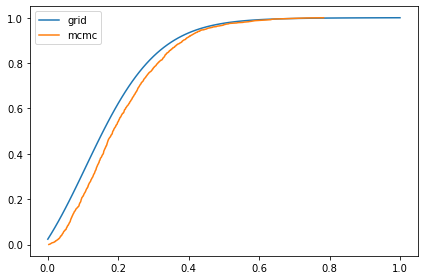

In [108]:
marginal_mu = Pmf(marginal(posterior, 0), mus)
compare_cdf(marginal_mu, trace1['mu'])

5.82857969107785 5.848888673080117


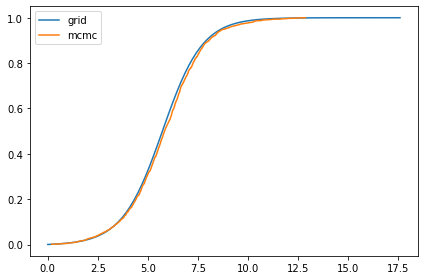

In [109]:
marginal_eta = Pmf(marginal(posterior, 1), prior_eta.qs)
compare_cdf(marginal_eta, trace1['eta'])

0.08942137261667622 0.09189836089439268


(0.08942137261667622, 0.09189836089439268)

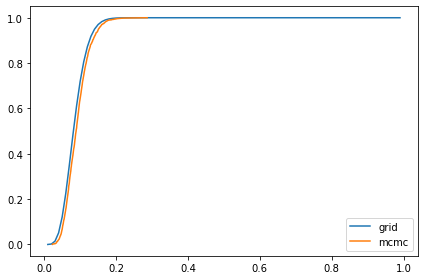

In [110]:
marginal_x = Pmf(marginal(posterior, 2), xs)
compare_cdf(marginal_x, trace1['x'])
marginal_x.mean(), trace1['x'].mean()

In [111]:
posterior_hyper = get_hyper(posterior)

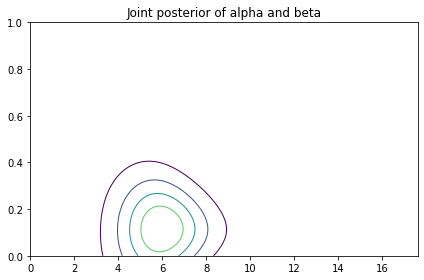

In [112]:
plot_contour(pd.DataFrame(posterior_hyper, 
                          index=mus, 
                          columns=etas))
decorate(title="Joint posterior of alpha and beta")

In [113]:
like_hyper = posterior_hyper / prior_hyper

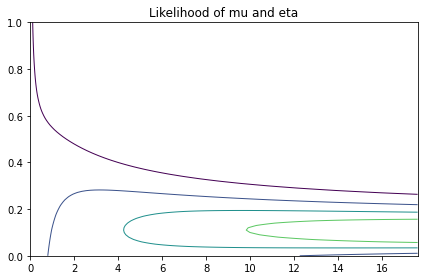

In [114]:
plot_contour(pd.DataFrame(like_hyper, 
                          index=mus, 
                          columns=etas))
decorate(title="Likelihood of mu and eta")

## Multiple updates

In [115]:
prior = make_prior(prior_hyper)
prior.shape

(101, 91, 99)

In [116]:
def multiple_updates(prior, ns, ks, xs):
    for data in zip(ns, ks):
        print(data)
        posterior = update(prior, data)
        hyper = get_hyper(posterior)
        prior = make_prior(hyper)
    return posterior

In [117]:
%time posterior = multiple_updates(prior, data_ns, data_ks, xs)

(129, 4)
(35, 1)
(228, 18)
(84, 7)
(291, 24)
(270, 16)
(46, 6)
(293, 19)
(241, 15)
(105, 13)
(353, 25)
(250, 11)
(41, 4)
CPU times: user 83.6 ms, sys: 9.36 ms, total: 92.9 ms
Wall time: 87 ms


0.09128353289662904 0.11878098424645436


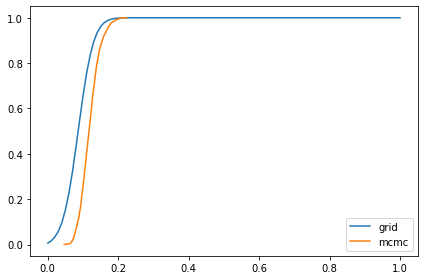

In [118]:
marginal_mu = Pmf(marginal(posterior, 0), mus)
compare_cdf(marginal_mu, trace['mu'])

7.311359174026014 8.203818020286597


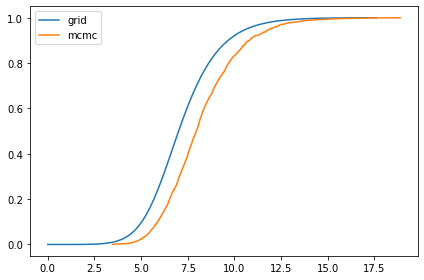

In [119]:
marginal_eta = Pmf(marginal(posterior, 1), etas)
compare_cdf(marginal_eta, trace['eta'])

0.09666584016357194 0.1013802074464486


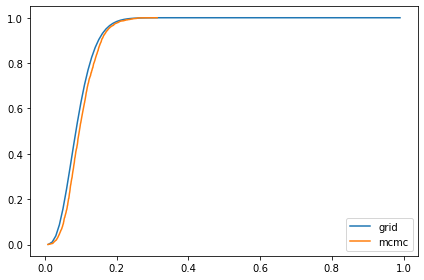

In [120]:
marginal_x = Pmf(marginal(posterior, 2), prior_x.qs)
compare_cdf(marginal_x, trace_xs[-1])

In [121]:
posterior_hyper = get_hyper(posterior)

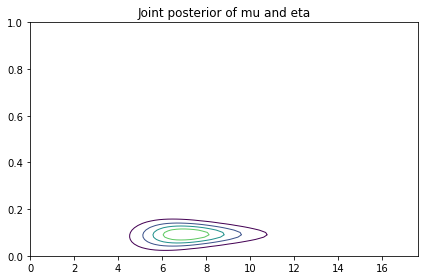

In [122]:
plot_contour(pd.DataFrame(posterior_hyper, 
                          index=mus, 
                          columns=etas))
decorate(title="Joint posterior of mu and eta")

In [123]:
like_hyper = posterior_hyper / prior_hyper

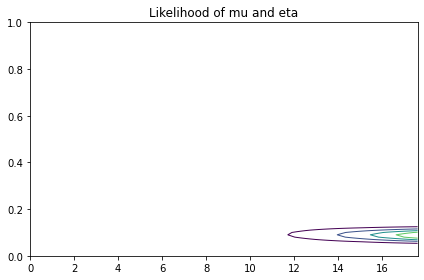

In [124]:
plot_contour(pd.DataFrame(like_hyper, 
                          index=mus, 
                          columns=etas))
decorate(title="Likelihood of mu and eta")

## One at a time

In [127]:
def compute_likes_hyper(ns, ks):
    shape = ns.shape + mus.shape + etas.shape
    likes_hyper = np.empty(shape)
    
    for i, data in enumerate(zip(ns, ks)):
        print(data)
        n, k = data
        like_x = binom.pmf(k, n, xs)
        posterior = betapdf * like_x
        likes_hyper[i] = posterior.sum(axis=2)
        print(likes_hyper[i].sum())
    return likes_hyper

In [128]:
%time likes_hyper = compute_likes_hyper(data_ns, data_ks)

(129, 4)
118.57959374299223
(35, 1)
403.7336767028497
(228, 18)
45.11918264818736
(84, 7)
119.55737812868458
(291, 24)
34.85722969061723
(270, 16)
42.40940140715342
(46, 6)
190.88482297910872
(293, 19)
37.737950229241655
(241, 15)
46.58137108344515
(105, 13)
85.42157804744473
(353, 25)
30.323175462696558
(250, 11)
51.98869738671179
(41, 4)
231.0017661603332
CPU times: user 44.7 ms, sys: 91 µs, total: 44.8 ms
Wall time: 38.1 ms


In [129]:
likes_hyper.sum()

1438.1958236694666

In [130]:
like_hyper_all = likes_hyper.prod(axis=0)
like_hyper_all.sum()

8.744895045506347e-17

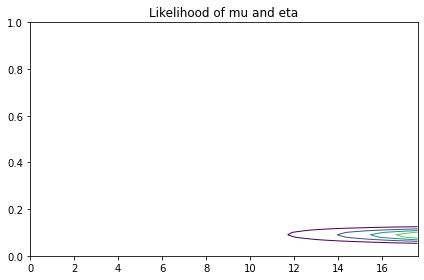

In [132]:
plot_contour(pd.DataFrame(like_hyper_all, 
                          index=mus, 
                          columns=etas))
decorate(title="Likelihood of mu and eta")

In [133]:
posterior_hyper_all = prior_hyper * like_hyper_all
posterior_hyper_all /= posterior_hyper_all.sum()

np.allclose(posterior_hyper_all, posterior_hyper)

True

True

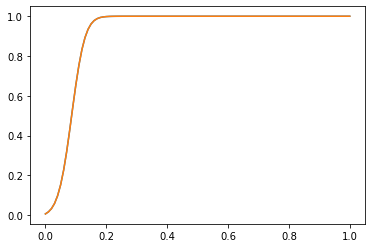

In [135]:
marginal_mu2 = Pmf(posterior_hyper_all.sum(axis=1), mus)
marginal_mu2.make_cdf().plot()
marginal_mu.make_cdf().plot()
np.allclose(marginal_mu, marginal_mu2)

True

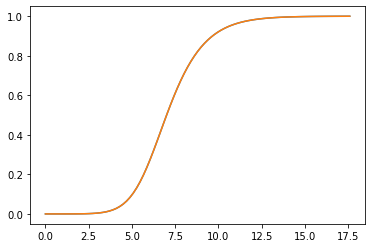

In [136]:
marginal_eta2 = Pmf(posterior_hyper_all.sum(axis=0), etas)
marginal_eta2.make_cdf().plot()
marginal_eta.make_cdf().plot()
np.allclose(marginal_eta, marginal_eta2)

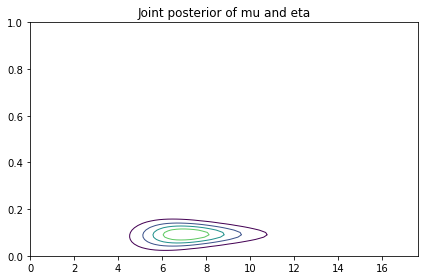

In [137]:
plot_contour(pd.DataFrame(posterior_hyper_all, 
                          index=mus, 
                          columns=etas))
decorate(title="Joint posterior of mu and eta")

In [138]:
i = 3
data = data_ns[i], data_ks[i]
data

(84, 7)

In [139]:
hyper_i = prior_hyper * like_hyper_all / likes_hyper[i]
hyper_i.sum()

3.7469377861778774e-20

In [140]:
prior_i = make_prior(hyper_i) 

In [141]:
posterior_i = update(prior_i, data)

<AxesSubplot:>

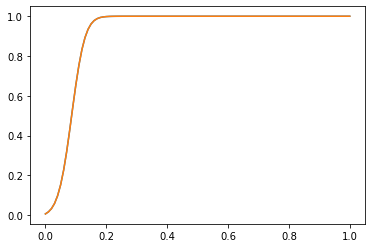

In [142]:
Pmf(marginal(posterior_i, 0), mus).make_cdf().plot()
marginal_mu.make_cdf().plot()

<AxesSubplot:>

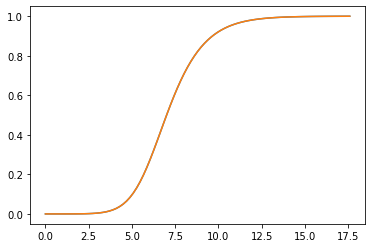

In [143]:
Pmf(marginal(posterior_i, 1), etas).make_cdf().plot()
marginal_eta.make_cdf().plot()

In [144]:
marginal_mu = Pmf(marginal(posterior_i, 0), mus)
marginal_eta = Pmf(marginal(posterior_i, 1), etas)
marginal_x = Pmf(marginal(posterior_i, 2), xs)

0.09128353289662901 0.11878098424645436


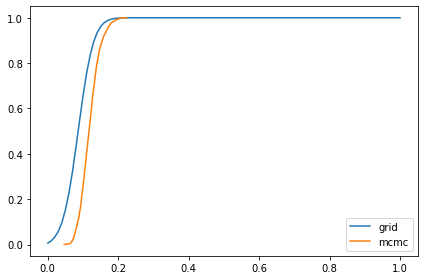

In [145]:
compare_cdf(marginal_mu, trace['mu'])

7.3113591740260135 8.203818020286597


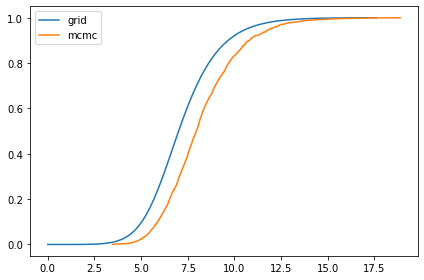

In [146]:
compare_cdf(marginal_eta, trace['eta'])

0.08399383447721634 0.08634849257722181


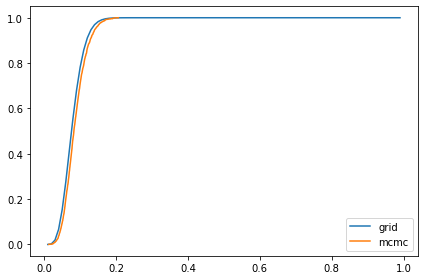

In [147]:
compare_cdf(marginal_x, trace_xs[i])

In [148]:
def compute_all_marginals(ns, ks):
    prior = prior_hyper * like_hyper_all
    
    for i, data in enumerate(zip(ns, ks)):
        print(data)
        n, k = data
        hyper_i = prior / likes_hyper[i]
        prior_i = make_prior(hyper_i) 
        posterior_i = update(prior_i, data)
        marginal_x = Pmf(marginal(posterior_i, 2), xs)
        marginal_x.make_cdf().plot()

(129, 4)
(35, 1)
(228, 18)
(84, 7)
(291, 24)
(270, 16)
(46, 6)
(293, 19)
(241, 15)
(105, 13)
(353, 25)
(250, 11)
(41, 4)
CPU times: user 209 ms, sys: 177 ms, total: 386 ms
Wall time: 183 ms


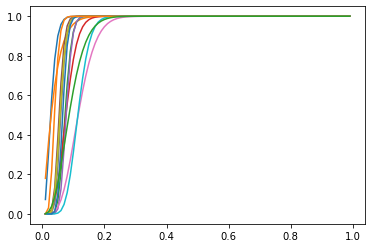

In [149]:
%time compute_all_marginals(data_ns, data_ks)